In [2]:
import math
from math import log2
import numpy as np
from scipy.stats import norm
from collections import Counter
from matplotlib import pyplot as plt

In [3]:
def evalDate(data, facts):
    i = 0
    for f in facts:
        i = (i << 1) | int(f(*data))
    return i


def evalData(data, facts):
    D = np.zeros((len(data), 1))
    for i, d in enumerate(data):
        D[i] = evalDate(d, facts)
    return D


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[..., i] = a
    return arr.reshape(-1, la)


def to_int(*args):
    i = 0
    for a in args:
        i = (i << 1) | int(a)
    return i

In [226]:
X_AGE = np.array(range(0, 51), dtype=int)
X_INCOME = np.array(range(0, 3001), dtype=int)

In [227]:
DATA = cartesian_product(X_AGE, X_INCOME)

In [228]:
PROB = np.zeros((len(DATA), 1))

In [229]:
FACTS1 = lambda age, income: to_int(age > 18, income >= 2000)
FACTS2 = lambda age, income: to_int(age > 25, income >= 1000, income <= 2000)

In [260]:
from scipy.stats import *


def dist(end, mu, std):
    p = np.zeros((end,))
    for i in range(end):
        p[i] = norm.pdf(i, mu, std)
    n = sum(p)
    return p / n


XXX = dist(51, 20, 10)
YYY = dist(3001, 1500, 1000)
prob_age = lambda x: XXX[x, 0]  # binom.pmf(x, 200, 0.1)
prob_income = lambda x: YYY[y, 0]  # randint.pmf(x, 500, 2500)

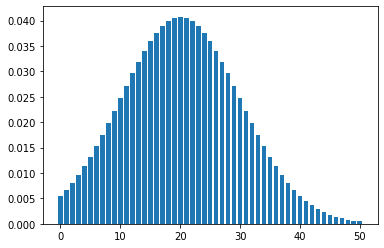

In [261]:
fig, ax1 = plt.subplots(1, 1)
Y_AGE = XXX
ax1.bar(X_AGE, Y_AGE)
fig.savefig('age_distribution.svg')

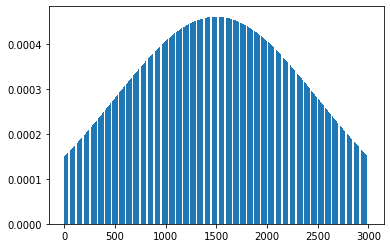

In [262]:
fig, ax2 = plt.subplots(1, 1)
ax2.bar(X_INCOME, YYY)
plt.savefig('income_distribution.svg')

In [263]:
with open("age.data", 'w') as fh:
    for v in enumerate(XXX): fh.write(f"{v}\n")
with open("income.data", 'w') as fh:
    for v in enumerate(YYY): fh.write(f"{v}\n")

In [264]:
def tax_rate(age, income):
    if age < 18: return 0
    if age < 25 and not (income > 1000):
        return 0.1
    if income <= 1000:
        return 0.2
    return 0.3

In [266]:
def joint_prob(age, income): return XXX[age] * YYY[income]


print(joint_prob(25, 1500))

O1 = np.zeros((len(DATA), 1))
O2 = np.zeros((len(DATA), 1))
R = np.zeros((len(DATA), 1))

1.6561463037445862e-05


In [267]:
for idx, d in enumerate(DATA):
    p = joint_prob(*d)
    PROB[idx] = p
    O1[idx] = FACTS1(*d)
    O2[idx] = FACTS2(*d)
    R[idx] = tax_rate(*d)

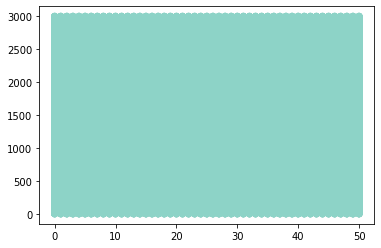

In [238]:
x = DATA[:, 0]
y = DATA[:, 1]

plt.figure()
plt.set_cmap('Set3')
plt.scatter(x, y, c=R * 3)
fig.savefig("R.png")

In [ ]:
plt.figure()
ax1.scatter(x, y, c=(O1 == 3))
fig.savefig("f1.png")

In [ ]:

plt.figure()
ax2.scatter(x, y, c=(O2 == 7))
fig.savefig("f2.png")


In [157]:
def models(out, true):
    c = Counter(out[:, 0])
    return c[true]

In [158]:
models(O1, 3)

31000

In [160]:
models(O2, 7)

24024

In [164]:
Counter(R[:, 0]).items()

dict_items([(0.0, 54000), (0.1, 7007), (0.3, 63968), (0.2, 25025)])

In [301]:
def min_entropy(data):
    c = Counter(data[:, 0])
    M = dict()
    for out in c.keys():
        current_max = 0;
        norm = 0
        for idx in range(len(PROB)):
            if data[idx, 0] == out:
                current_max = max(PROB[idx, 0], current_max)
                norm += PROB[idx, 0]
        M[out] = current_max / norm
    B = sum(M.values())
    A = max(PROB)
    return -A - (- B)

In [302]:
A = min_entropy(O1)
B = min_entropy(O2)
C = min_entropy(R)

In [304]:
A < B

array([ True])

In [295]:
def V(Px): return max(Px)
def Hinfty(Px): log2(1 / V(Px))
def Hinfty_cond(PXY, PY): return log2(1 / Vcond(PXY,PY))

def V_cond_y(PXY, idx):
    return max(PXY[:, idx])

def Vcond(PXY, PY):
    s = 0
    for idxY, Py in enumerate(PY):
        s += Py * V_cond_y(PXY, y)
    return s

def Leakage(PX, PY, PXY): return Hinfty(PX) - Hinfty_cond(PXY,PY)

In [298]:
PY = dict()
PXY = np.zeros((3001*51, 4 ))
for idx, out in enumerate(O1):
    p = PROB[idx,0]
    y = PY.get(out[0], 0)
    v = p+y
    PY[out[0]] = v
    PXY[idx,int(out)] = 1
PY
#Leakage(PROB, PY, PXY)

{0.0: 0.3094582646646882,
 1.0: 0.11989542857703349,
 2.0: 0.4112954391830746,
 3.0: 0.1593508675752021}